<a href="https://colab.research.google.com/github/varshin99/NLP/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas pyarrow
!pip install emoji
!python -m spacy download en_core_web_trf
#!pip install -U spacy[cuda] spacy-transformers

2023-12-06 07:37:15.018637: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 07:37:15.018718: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 07:37:15.018776: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 07:37:15.032068: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 07:37:18.258437: W tensorflow/compiler/

In [3]:
!pip install allennlp

In [4]:
!pip install emoji

In [5]:
import re, nltk, emoji, torch, nltk
import numpy as np
from numpy import asarray, zeros
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import XLNetModel, XLNetTokenizer, BertTokenizer, BertModel
from allennlp.modules.elmo import Elmo, batch_to_ids
from gensim import models
print("Success!")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Success!


In [6]:
#Importing Libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import emoji
import seaborn as sns

In [7]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Path to the Feather file on Google Drive
file_path = '/content/drive/My Drive/output_april.feather'

df = pd.read_feather(file_path)
df_final=pd.read_feather(file_path)

**EDA**

In [ ]:
df.head()

,text,tweetid,userid,date,rt_id,rt_userid
0,RT @BernieSanders: Climate change is already h...,716973593406660610,706471600288370690,Mon Apr 04 13:00:00 +0000 2016,716648966520053760,216776631
1,@realDonaldTrump can u get 10 vets to go wit...,716973594668994561,2165390978,Mon Apr 04 13:00:00 +0000 2016,None,None
2,@realDonaldTrump Only a #moron thinks tariffs ...,716973600050286594,4445513772,Mon Apr 04 13:00:01 +0000 2016,None,None
3,RT @BernieSanders: Let me be clear: I have con...,716973603984637953,706471600288370690,Mon Apr 04 13:00:02 +0000 2016,716806019842646016,216776631
4,"RT @realDonaldTrump: Thank you New York, and P...",716973604144078848,225068092,Mon Apr 04 13:00:02 +0000 2016,716683752227913728,25073877


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4810476 entries, 0 to 4810475
Data columns (total 6 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   text       object
 1   tweetid    object
 2   userid     object
 3   date       object
 4   rt_id      object
 5   rt_userid  object
dtypes: object(6)
memory usage: 220.2+ MB


In [ ]:
unique_userid_count = df['userid'].nunique()
print(unique_userid_count)
# there are 844898 unique users in this dataset.

844898


In [ ]:
def count_null_values(df):
    null_counts = df.isnull().sum()
    return null_counts
null_counts = count_null_values(df)
print("count of nulls in the every columns")
print(null_counts)
# there are null values in the rt_id and rt_userid attributes.

count of nulls in the every columns
text               0
tweetid            0
userid             0
date               0
rt_id        1382461
rt_userid    1382461
dtype: int64


In [ ]:
selected_data = df.loc[df['rt_id'] == '716688097237458945', ['text', 'tweetid','userid','date','rt_id','rt_userid']]
selected_data.head()
#Once we gone through all the null values, we relaized that we cant remove all the nuill values becuse those are tweets that are not retweed by anyone
#these are still usefull the analysis, so we are goine impute with "No_one_retweeted" on the both columns


,text,tweetid,userid,date,rt_id,rt_userid
90,RT @realDonaldTrump: Thank you Miss Katie's Di...,716974102431404033,3320760763,Mon Apr 04 13:02:01 +0000 2016,716688097237458945,25073877
236,RT @realDonaldTrump: Thank you Miss Katie's Di...,716974808492335104,213989297,Mon Apr 04 13:04:49 +0000 2016,716688097237458945,25073877
329,RT @realDonaldTrump: Thank you Miss Katie's Di...,716975286076776450,34603594,Mon Apr 04 13:06:43 +0000 2016,716688097237458945,25073877
334,RT @realDonaldTrump: Thank you Miss Katie's Di...,716975305026617344,4851493023,Mon Apr 04 13:06:48 +0000 2016,716688097237458945,25073877
502,RT @realDonaldTrump: Thank you Miss Katie's Di...,716975856644567040,52141764,Mon Apr 04 13:08:59 +0000 2016,716688097237458945,25073877


In [ ]:
duplicates = df[df.duplicated()]
duplicates.head()
# The following dataset contians all the duplicates in df dataset

,text,tweetid,userid,date,rt_id,rt_userid
1021,@HillaryClinton why not? taxpayers should NOT ...,716977216714776576,238617719,Mon Apr 04 13:14:23 +0000 2016,None,None
1022,RT @realDonaldTrump: Thank you Miss Katie's Di...,716977211677544448,28648300,Mon Apr 04 13:14:22 +0000 2016,716688097237458945,25073877
1023,@HillaryClinton so are u going to get rid of O...,716977245944995844,807201294,Mon Apr 04 13:14:30 +0000 2016,None,None
1024,RT @TexasTribune: .@tedcruz launches final pus...,716977245307338752,3243895087,Mon Apr 04 13:14:30 +0000 2016,716832938696974336,44513878
1025,@HillaryClinton how much do we pay and adminis...,716977311292264448,2915425457,Mon Apr 04 13:14:46 +0000 2016,None,None


In [ ]:
duplicates.count()
# so there are 146552 duplicate in the dataset so we are gone remove these duplicates from the dataset

text         146552
tweetid      146552
userid       146552
date         146552
rt_id        105691
rt_userid    105691
dtype: int64

In [ ]:
# dropping all the duplicates from the dataset.
df.drop_duplicates(subset='userid', inplace=True)

Since the data type of your columns is mostly object, identifying numerical outliers may not be relevant.

In [ ]:

df = pd.DataFrame(df)

# Convert the 'date' column into datetime format
df['datetime'] = pd.to_datetime(df['date'], format='%a %b %d %H:%M:%S +0000 %Y')

# Extract individual components
df['day_of_week'] = df['datetime'].dt.strftime('%A')
df['month'] = df['datetime'].dt.strftime('%B')
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second
df['year'] = df['datetime'].dt.year
df['timezone'] = df['date'].str.split(' ').str[4]

# Drop the original 'date' column and 'datetime' column if not needed
df = df.drop(columns=['date', 'datetime'])



In [ ]:
df.head()

,text,tweetid,userid,rt_id,rt_userid,day_of_week,month,day,hour,minute,second,year,timezone
0,RT @BernieSanders: Climate change is already h...,716973593406660610,706471600288370690,716648966520053760,216776631,Monday,April,4,13,0,0,2016,+0000
1,@realDonaldTrump can u get 10 vets to go wit...,716973594668994561,2165390978,None,None,Monday,April,4,13,0,0,2016,+0000
2,@realDonaldTrump Only a #moron thinks tariffs ...,716973600050286594,4445513772,None,None,Monday,April,4,13,0,1,2016,+0000
4,"RT @realDonaldTrump: Thank you New York, and P...",716973604144078848,225068092,716683752227913728,25073877,Monday,April,4,13,0,2,2016,+0000
5,RT @tedcruz: TOMORROW: #ChooseCruz in Wisconsi...,716973613287673856,868717914,716962622898196480,23022687,Monday,April,4,13,0,4,2016,+0000


In [ ]:

df.isnull().sum()

text                0
tweetid             0
userid              0
rt_id          261495
rt_userid      261495
day_of_week         0
month               0
day                 0
hour                0
minute              0
second              0
year                0
timezone            0
dtype: int64

Histograms

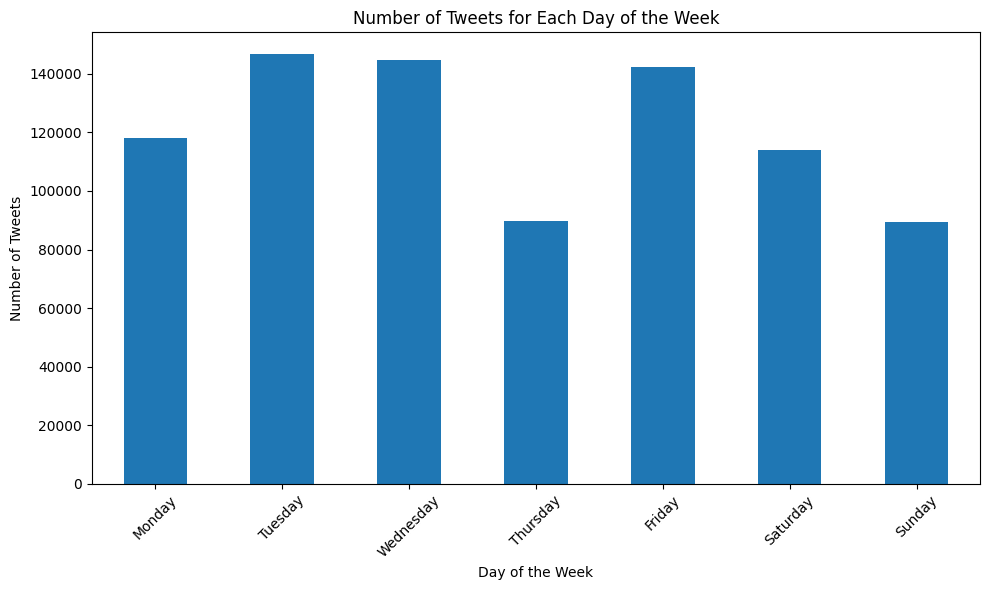

In [ ]:
# Group by 'day_of_week' and count tweets
tweets_by_day = df.groupby('day_of_week').size().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']).fillna(0)

# Plot the bar graph
tweets_by_day.plot(kind='bar', figsize=(10,6))
plt.title('Number of Tweets for Each Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

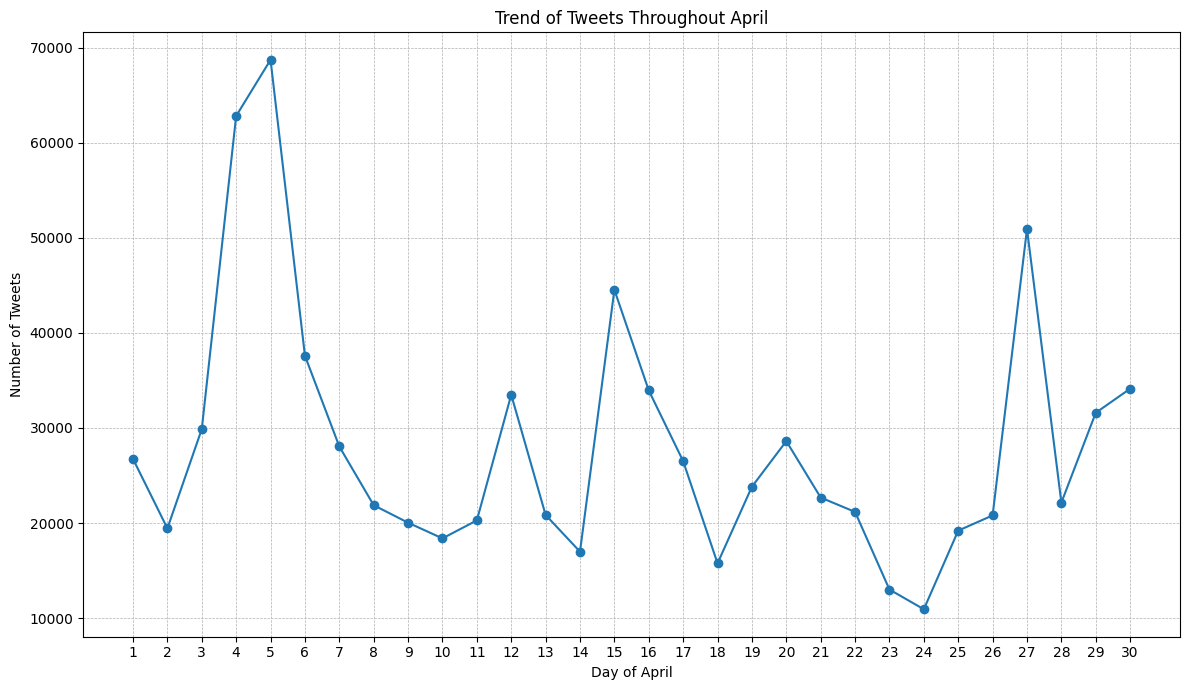

In [ ]:
# Group by 'day' (which you've extracted previously) and count tweets
daily_tweet_counts = df.groupby('day').size()

# Plot the trendline
plt.figure(figsize=(12, 7))
daily_tweet_counts.plot(kind='line', marker='o')
plt.title('Trend of Tweets Throughout April')
plt.xlabel('Day of April')
plt.ylabel('Number of Tweets')
plt.xticks(range(1, 31), range(1, 31))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
#This code will show a trendline indicating the number of tweets for each day in April. The markers ('o') represent each day, and the
#line shows the trend of tweets throughout the month.

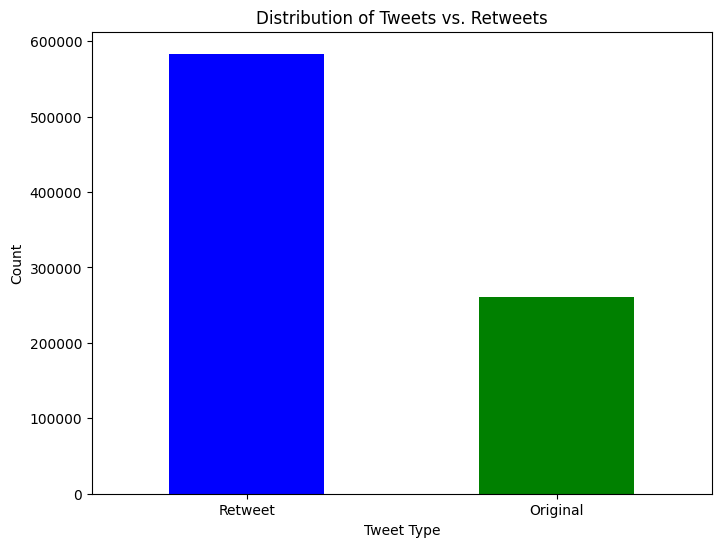

In [ ]:
# Assuming your dataframe is named df
# Create a new column categorizing tweets as "Original" or "Retweet"
df['tweet_type'] = df['rt_id'].apply(lambda x: "Retweet" if pd.notnull(x) else "Original")

# Get counts for each category
tweet_counts = df['tweet_type'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
tweet_counts.plot(kind='bar', color=['blue', 'green'])
plt.title('Distribution of Tweets vs. Retweets')
plt.xlabel('Tweet Type')
plt.ylabel('Count')
plt.xticks(rotation=0)  # This will keep the x-labels horizontal
plt.show()

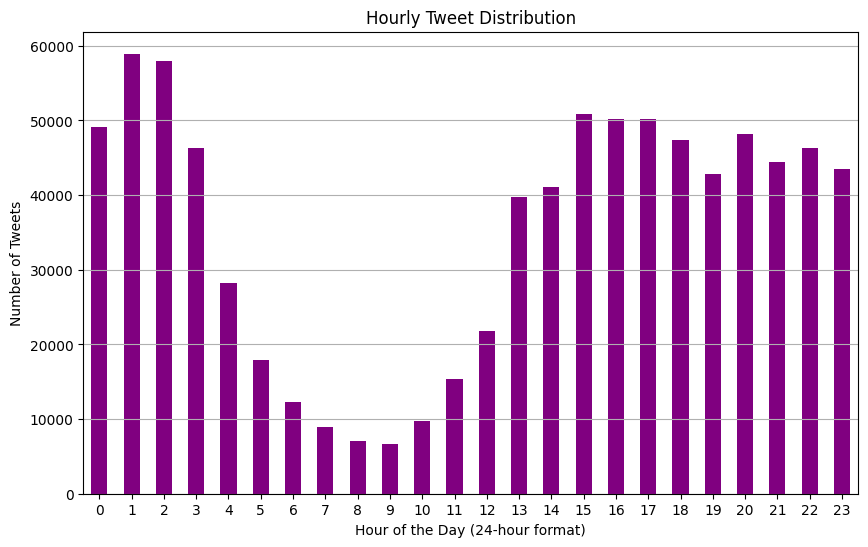

In [ ]:
# Group by the 'hour' column and get the count of tweets for each hour
hourly_tweets = df.groupby('hour').size()

# Plot
plt.figure(figsize=(10, 6))
hourly_tweets.plot(kind='bar', color='purple')
plt.title('Hourly Tweet Distribution')
plt.xlabel('Hour of the Day (24-hour format)')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)  # This will keep the x-labels horizontal
plt.grid(axis='y')  # Adds a grid for better readability
plt.show()

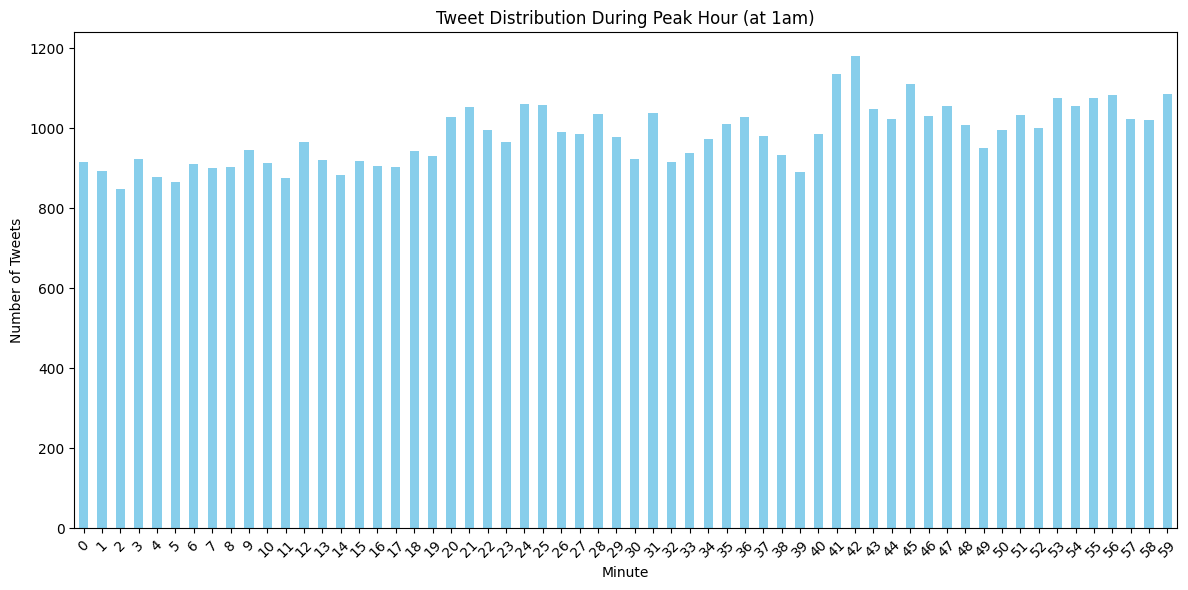

In [ ]:
# Filtering the dataframe for tweets at 1am
peak_hour_df = df[df['hour'] == 1]

# Grouping by minute and counting the tweets
tweets_per_minute = peak_hour_df.groupby('minute').size()

# Plotting the histogram
plt.figure(figsize=(12, 6))
tweets_per_minute.plot(kind='bar', color='skyblue')
plt.title('Tweet Distribution During Peak Hour (at 1am)')
plt.xlabel('Minute')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

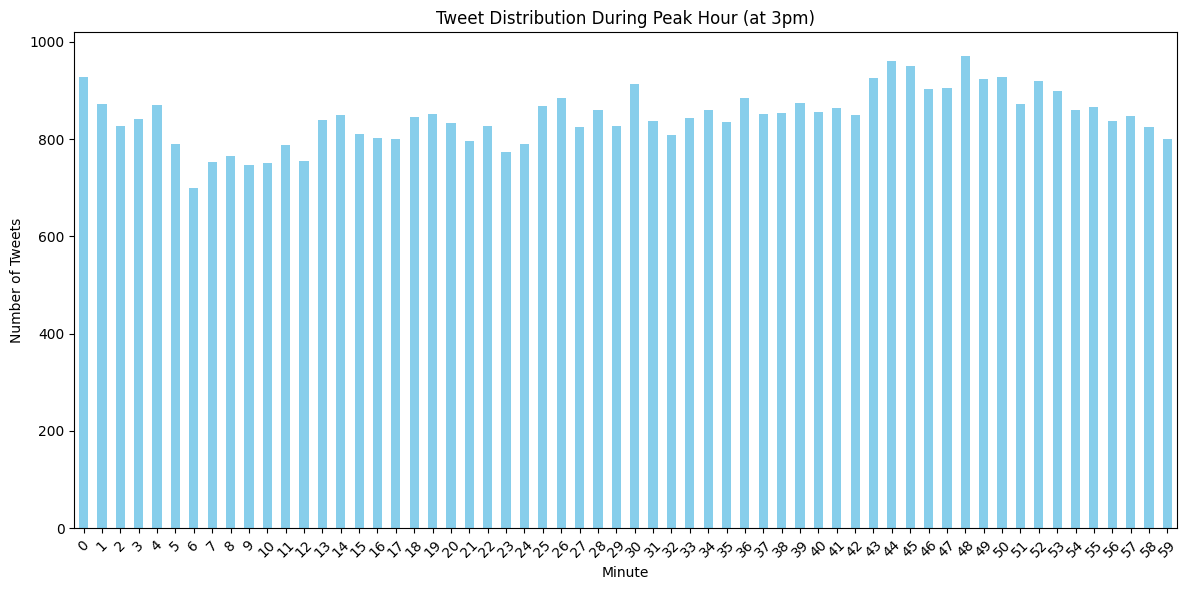

In [ ]:
# Filtering the dataframe for tweets at 3pm
peak_hour_df = df[df['hour'] == 15]

# Grouping by minute and counting the tweets
tweets_per_minute = peak_hour_df.groupby('minute').size()

# Plotting the histogram
plt.figure(figsize=(12, 6))
tweets_per_minute.plot(kind='bar', color='skyblue')
plt.title('Tweet Distribution During Peak Hour (at 3pm)')
plt.xlabel('Minute')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

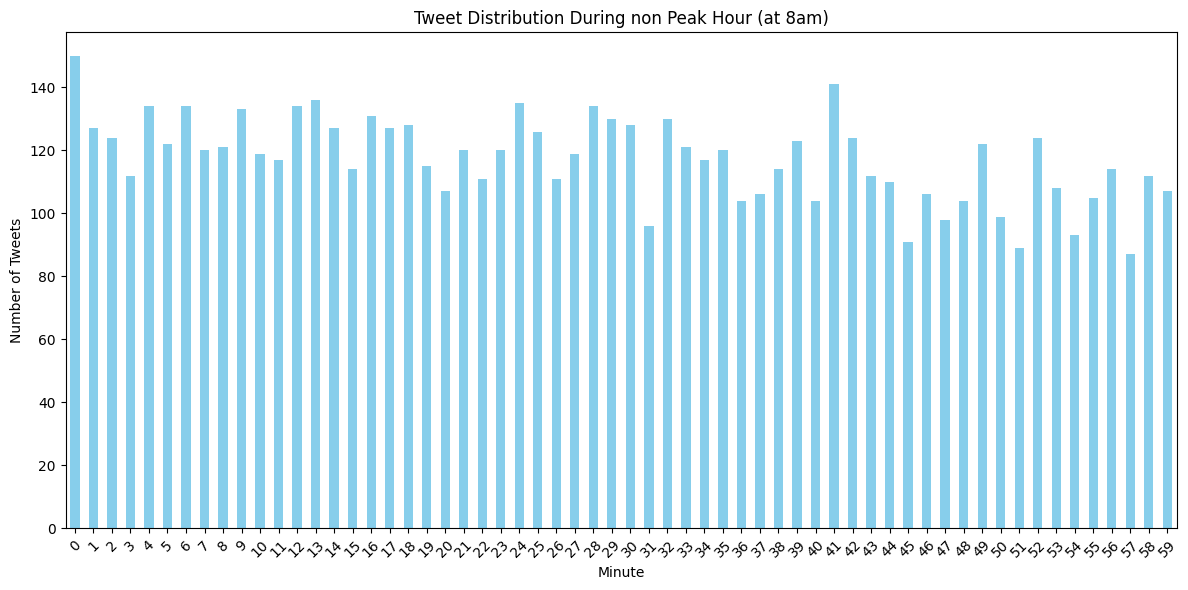

In [ ]:
# Filtering the dataframe for tweets at 8am
peak_hour_df = df[df['hour'] == 8]

# Grouping by minute and counting the tweets
tweets_per_minute = peak_hour_df.groupby('minute').size()

# Plotting the histogram
plt.figure(figsize=(12, 6))
tweets_per_minute.plot(kind='bar', color='skyblue')
plt.title('Tweet Distribution During non Peak Hour (at 8am)')
plt.xlabel('Minute')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Check if a tweet contains a link
df['contains_link'] = df['text'].str.contains('http://|https://|www\.')

# Count the tweets with and without links
link_counts = df['contains_link'].value_counts()

link_counts


False    572301
True     272597
Name: contains_link, dtype: int64

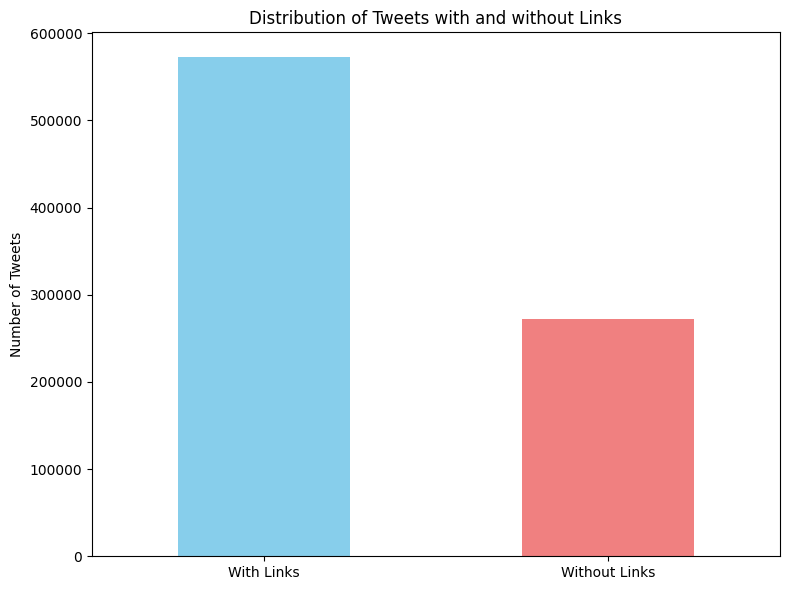

In [ ]:
# Plotting
plt.figure(figsize=(8, 6))
link_counts.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Distribution of Tweets with and without Links')
plt.xticks([0, 1], ['With Links', 'Without Links'], rotation=0)
plt.ylabel('Number of Tweets')
plt.tight_layout()
plt.show()


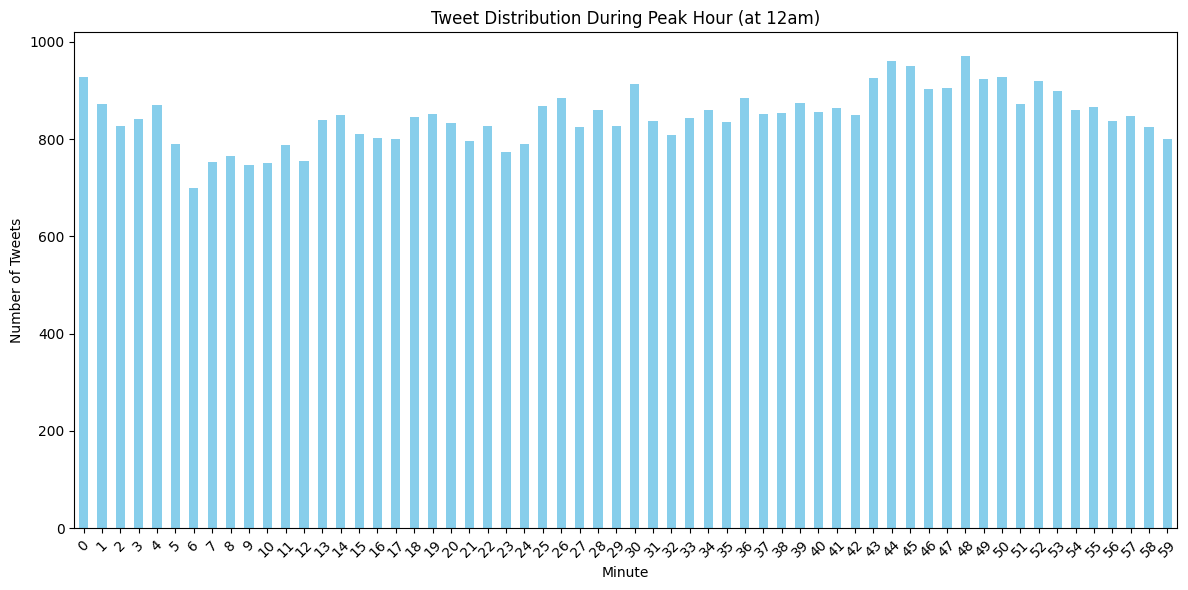

In [ ]:
# Filtering the dataframe for tweets at 3pm
peak_hour_df = df[df['hour'] == 15]

# Grouping by minute and counting the tweets
tweets_per_minute = peak_hour_df.groupby('minute').size()

# Plotting the histogram
plt.figure(figsize=(12, 6))
tweets_per_minute.plot(kind='bar', color='skyblue')
plt.title('Tweet Distribution During Peak Hour (at 12am)')
plt.xlabel('Minute')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

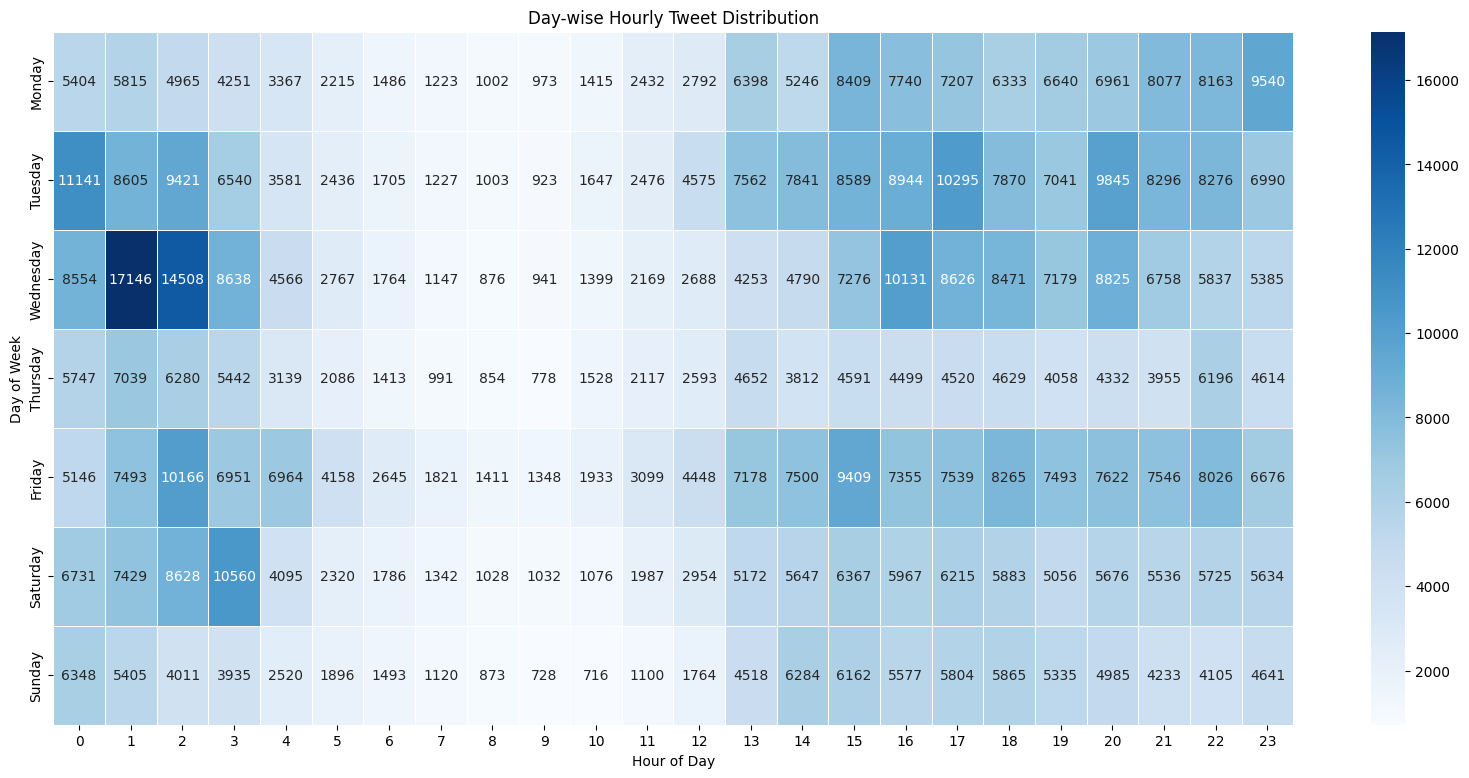

In [ ]:
# Create a pivot table for the heatmap
pivot_df = df.pivot_table(index='day_of_week', columns='hour', aggfunc='size', fill_value=0)

# If you want the days to appear in order, you might want to reorder the index
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pivot_df = pivot_df.reindex(order)
plt.figure(figsize=(20, 9))
sns.heatmap(pivot_df, cmap='Blues', linewidths=.5, annot=True, fmt="d")

plt.title('Day-wise Hourly Tweet Distribution')
plt.ylabel('Day of Week')
plt.xlabel('Hour of Day')
plt.show()


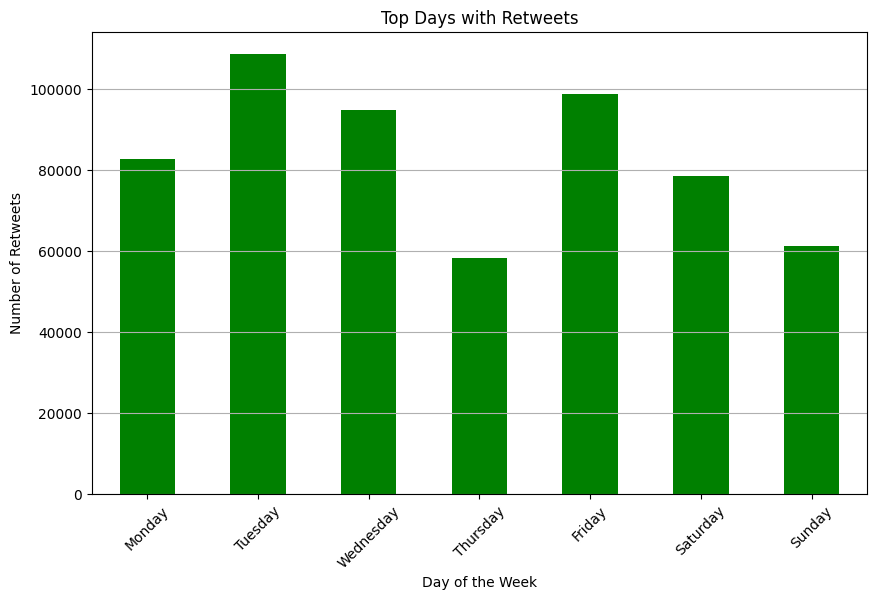

In [ ]:
retweets_data = df[df['rt_id'].notna()]
retweets_by_day = retweets_data.groupby('day_of_week').size()

order_of_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sorted_retweets = retweets_by_day.loc[order_of_days]
plt.figure(figsize=(10, 6))
sorted_retweets.plot(kind='bar', color='green')

plt.title('Top Days with Retweets')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Retweets')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()


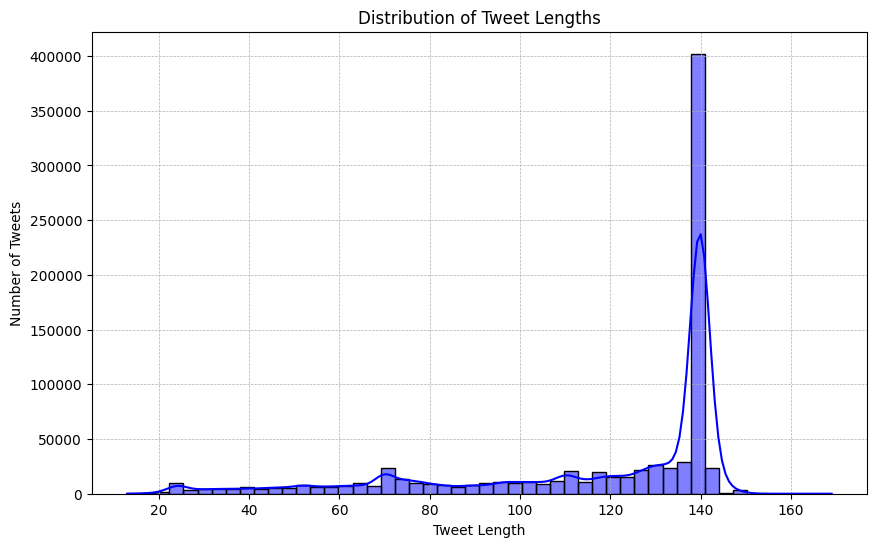

In [ ]:

df['tweet_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['tweet_length'], bins=50, kde=True, color='blue')

plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Number of Tweets')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128079 (\N{CLAPPING HANDS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127995 (\N{EMOJI MODIFIER FITZPATRICK TYPE-1-2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, 

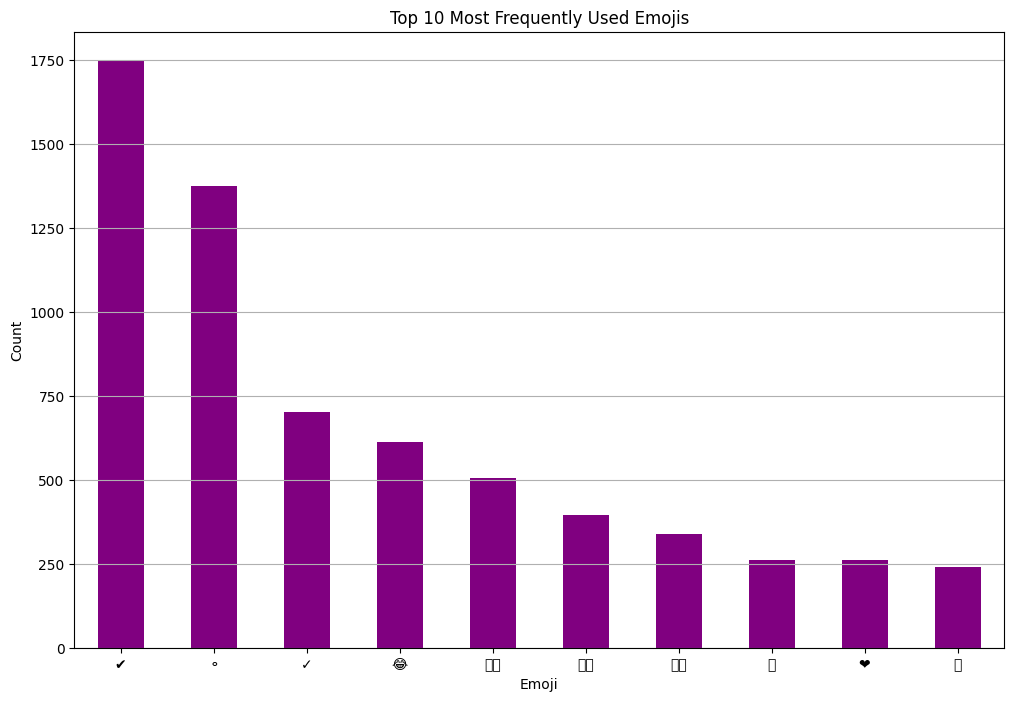

In [ ]:
def extract_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.findall(text)

df['emojis'] = df['text'].apply(extract_emojis)
emoji_counts = df['emojis'].explode().value_counts()

# Visualize the results
plt.figure(figsize=(12, 8))
emoji_counts.head(10).plot(kind='bar', color='purple')
plt.title('Top 10 Most Frequently Used Emojis')
plt.xlabel('Emoji')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


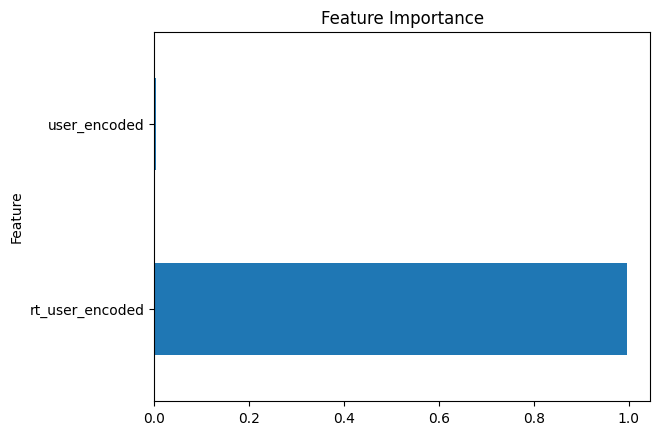

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Creating a binary target variable: 1 if retweet, 0 if original tweet
df['is_retweet'] = ~df['rt_id'].isnull()

# Encoding categorical columns
le_userid = LabelEncoder()
le_rt_userid = LabelEncoder()

df['user_encoded'] = le_userid.fit_transform(df['userid'].astype(str))
df['rt_user_encoded'] = le_rt_userid.fit_transform(df['rt_userid'].astype(str))

# Assuming 'is_retweet' is the target for classification
X = df[['user_encoded', 'rt_user_encoded']]
y = df['is_retweet']

# Train a RandomForest Classifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

# Get feature importance
feature_importance = clf.feature_importances_

# Visualizing feature importance
features_df = pd.DataFrame({
    'Feature': ['user_encoded', 'rt_user_encoded'],
    'Importance': feature_importance
})

features_df.sort_values(by='Importance', ascending=False).plot(x='Feature', y='Importance', kind='barh', legend=False)
plt.title('Feature Importance')
plt.show()


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844898 entries, 0 to 4810462
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             844898 non-null  object
 1   tweetid          844898 non-null  object
 2   userid           844898 non-null  object
 3   rt_id            583403 non-null  object
 4   rt_userid        583403 non-null  object
 5   day_of_week      844898 non-null  object
 6   month            844898 non-null  object
 7   day              844898 non-null  int64 
 8   hour             844898 non-null  int64 
 9   minute           844898 non-null  int64 
 10  second           844898 non-null  int64 
 11  year             844898 non-null  int64 
 12  timezone         844898 non-null  object
 13  tweet_type       844898 non-null  object
 14  contains_link    844898 non-null  bool  
 15  tweet_length     844898 non-null  int64 
 16  emojis           844898 non-null  object
 17  is_retwee

In [ ]:
df

,text,tweetid,userid,rt_id,rt_userid,day_of_week,month,day,hour,minute,second,year,timezone,tweet_type,contains_link,tweet_length,emojis,is_retweet,user_encoded,rt_user_encoded
0,RT @BernieSanders: Climate change is already h...,716973593406660610,706471600288370690,716648966520053760,216776631,Monday,April,4,13,0,0,2016,+0000,Retweet,False,140,[],True,727044,304
1,@realDonaldTrump can u get 10 vets to go wit...,716973594668994561,2165390978,None,None,Monday,April,4,13,0,0,2016,+0000,Original,False,90,[],False,183432,836
2,@realDonaldTrump Only a #moron thinks tariffs ...,716973600050286594,4445513772,None,None,Monday,April,4,13,0,1,2016,+0000,Original,False,85,[],False,577062,836
4,"RT @realDonaldTrump: Thank you New York, and P...",716973604144078848,225068092,716683752227913728,25073877,Monday,April,4,13,0,2,2016,+0000,Retweet,True,117,[],True,204062,377
5,RT @tedcruz: TOMORROW: #ChooseCruz in Wisconsi...,716973613287673856,868717914,716962622898196480,23022687,Monday,April,4,13,0,4,2016,+0000,Retweet,True,96,[],True,816459,332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4810432,@SenWarren @SenateGOP What they haven't spent ...,725852027503288320,3219838165,None,None,Friday,April,29,0,59,43,2016,+0000,Original,False,82,[],False,422852,836
4810437,@HillaryClinton are u sure #moroccansahara,725852031991332864,25757226,None,None,Friday,April,29,0,59,44,2016,+0000,Original,False,42,[],False,284424,836
4810440,"RT @realDonaldTrump: Thank you Evansville, Ind...",725852033559961600,741736255,725796339255267328,25073877,Friday,April,29,0,59,45,2016,+0000,Retweet,True,99,[],True,785856,377
4810459,RT @SenSanders: Income should not determine wh...,725852072936091648,247555859,725810360742219776,29442313,Friday,April,29,0,59,54,2016,+0000,Retweet,False,140,[],True,261682,454


In [9]:
def char_is_emoji(character):
    #en_emoji = emoji.UNICODE_EMOJI.get("en")
    #return character[0] in emoji.UNICODE_EMOJI_ENGLISH
    return emoji.is_emoji(character[0])  #check out the API for emoji here: https://carpedm20.github.io/emoji/docs/api.html#

# Let's test it with a couple of examples

In [10]:
# Now we will add a layer to test every character in a string to see if it
# is an emoji.
def text_has_emoji(text):
    for character in text:
        if char_is_emoji(character):
            return True
    return False

text_has_emoji("Python is go!"), text_has_emoji("Python is go 👍")

(False, True)

In [11]:


slangs = {"afap":"as far as possible", "aab":"average at best", "aak":"alive and kicking", "aamof":"as a matter of fact", "aap":"always a pleasure", "aar":"at any rate", "aayf":"as always: your friend", "abd":"already been done", "admin":"administrator", "adn":"any day now", "aeae":"and ever and ever", "aeap":"as early as possible", "afaiac":"as far as i am concerned", "afaic":"as far as i am concerned", "afaics":"as far as i can see", "afaict":"as far as i can tell", "afaik":"as far as i know", "afair":"as far as i remember", "afc":"always from computer", "agw":"all going well", "afd":"all fucking day", "aft":"about fucking time", "b4":"before", "bb":"bye bye", "bbiab":"be back in a bit", "bbl":"be back later", "bbs":"be back soon", "bd":"big deal", "brb":"be right back", "brt":"be right there", "btw":"by the way", "cu":"see you", "cul":"see you later", "cuz":"because", "cya":"see you", "da":"the", "dat":"that", "der":"there", "dunno":"do not know", "fwiw":"for what it is worth", "fyi":"for your information", "g2g":"got to go", "gtg":"got to go", "gal":"get a life", "gfy":"good for you", "gonna":"going to", "icydk":"in case you do not know", "idgi":"i do not get it", "idk":"i do not know", "ily":"i love you", "ilu":"i love you", "imho":"in my honest opinion", "imo":"in my opinion", "irl":"in real life", "jj":"just joking", "jk":"just kidding", "k":"okay", "kk":"ok cool", "l8r":"later", "lmao":"laughing my ass off", "lmfao":"laughing my fucking ass off", "lol":"laughing out loud", "myob":"mind your own business", "noyb":"none of your business", "np":"no problem", "nsfw":"not safe for work", "nvm":"never mind", "omg":"oh my god", "pic":"picture", "ot":"off topic", "pix":"pictures", "plz":"please", "pls":"please", "ppl":"people", "rofl":"rolling on the floor laughing", "roflmao":"rolling on the floor laughing my ass off", "roflmaol":"rolling on the floor laughing my ass out loud", "smh":"shaking my head", "thnx":"thanks", "tho":"though", "tia":"thanks in advance", "ttyl":"talk to you later", "ttyt":"talk to you tomorrow", "ty":"thank you", "u":"you", "w8":"wait", "wanna":"want to", "wb":"welcome back", "wd":"well done", "im":"i am", "you've":"you have", "how'd":"how did", "i'm":"i am", "n't":"not", "we're":"we are", "you're":"you are"}
negated = {"weren't":"were not", "hadn't": "had not", "wouldn't": "would not", "mustn't": "must not", "aren't": "are not", "wasn't": "was not", "couldn't": "could not", "shan't": "shall not", "haven't": "have not", "mightn't": "might not", "doesn't": "does not", "needn't": "need not", "don't": "do not", "isn't": "is not", "hasn't": "has not", "doesn't": "does not", "didn't": "did not", "won't": "will not", "oughtn't": "ought not", "shouldn't": "should not", "cannot": "can not", "can't": "can not"}
emoticons = ["[: )", ":-]", ":-3", ":->", "8-)", ":-}", ":)", ":]", ":3", ":>", "8)", ":}", ":o)", ":c)", ":^)", "=]", "=)", ":-))", ": D", "8 D", "x D", "X D", ":D", "8D", "xD", "XD", "=D", "=3", "B^D", ":-*", ":*", ":×'", "; )", "*-)", "; ]", ";)", "*)", ";]", ";^)", ": ,", ";D", "<3", "(:", ": (", ": c", ": <", ": [", ":(", ":c", ":<", ":[", ":-||", ">:[", ":{", ":@", ">:(", ":' (", ":'(", "D ':", "D:<", "D:", "D8", "D;", "D=", "DX", ": O", ": o", ":O", ":o", ":-0", "8 0", ">:O"]

type(slangs), type(negated), type(emoticons)

(dict, dict, list)

In [12]:
# Next we will use our emoji finder to clean up the texts of a list of tweets.
# This function tokenizes the input and does many different transformations
# to the text and the tokens.



def clean_tweets(text):
        cleaned_tweets ='' # This will be our return list
        hash_emos = [] # This is an overall list of emoticons and emojis

    # Loop over the full list of texts provided
          # Simulating a delay
        hash_emo = [] # Initialize an empty list for this one text

        # These make substitutions of short tags in place of repeating
        # exclamation marks and/or question marks.
        text = re.sub('(!){2,}', ' <!repeat> ', text)
        text = re.sub('(\?){2,}', ' <?repeat> ', text)

        # Tokenize using tweet tokenizer: This will treat each emoji as
        # its own token.
        tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=False, reduce_len=True)
        tokens = tokenizer.tokenize(text.lower())
        lemmatizer = WordNetLemmatizer()


        # Emojis and emoticons
        if text_has_emoji(text): # Examine the untokenized text
            temp = [] # Make temporary storage for the modified tokens
            for tok in tokens: # Cycle through each token in this text
                # If the token is an emoji, look up the equivalent
                # plain text placeholder.
                if char_is_emoji(tok):
                    temp.append(emoji.demojize(tok))
                elif tok in emoticons:
                    temp.append(tok)
                else:
                    temp.append(tok)
            tokens = temp

        # Hashtags
        temp = []
        for word in tokens:
            if '#' in word: # Do a simple substitution using the empty string
                word = word.replace('#','')
                temp.append(word)
            else:
                temp.append(word)
        tokens = temp

        # Replace slangs and negated words
        temp = []
        for word in tokens:
            if word in slangs:
                temp += slangs[word].split()

            elif word in negated:
                temp += negated[word].split()

            else:
                temp.append(word)

        tokens = temp

        # Replace user names
        tokens = ['<user>'  if '@' in word else word for word in tokens]

        #Replace numbers
        tokens = ['<number>' if word.isdigit() else word for word in tokens]

        # Remove urls
        tokens = ['' if 'http' in word else word for word in tokens]

        # Lemmatize
        #tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # Remove stop words
        tokens = [word for word in tokens if word not in nltk.corpus.stopwords.words('english')]

        # Remove tokens having length 1
        tokens = [word for word in tokens if word != '' and len(word) > 1]

        cleaned_tweets=tokens

        return ' '.join(cleaned_tweets)

In [13]:
import time

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4810476 entries, 0 to 4810475
Data columns (total 6 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   text       object
 1   tweetid    object
 2   userid     object
 3   date       object
 4   rt_id      object
 5   rt_userid  object
dtypes: object(6)
memory usage: 220.2+ MB


In [79]:
df_final_2=df_final[:10000]
start_time = time.time()
df_final_2["clean_data"]=df_final_2['text'].apply(clean_tweets)

end_time = time.time()  # End time
total_time = end_time - start_time

print(f"The function took {total_time/60} seconds to run.")

The function took 0.42535619338353475 seconds to run.


<ipython-input-79-affbec6591b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_2["clean_data"]=df_final_2['text'].apply(clean_tweets)


In [80]:
import spacy
import torch
from collections import Counter
import time

# Check if the GPU is available and then set PyTorch to use the GPU
if torch.cuda.is_available():
    spacy.require_gpu()

# Load the spaCy model
nlp = spacy.load("en_core_web_trf")

# Assuming 'df_final_2' is a DataFrame and 'clean_data' column contains the text
texts = df_final_2['clean_data'].astype(str).tolist()

start_time = time.time()

# Process texts as a stream using nlp.pipe
docs = nlp.pipe(texts, batch_size=32)

# Count entities in all the documents
entity_counter = Counter()
for doc in docs:
    entities = [ent.text for ent in doc.ents]
    entity_counter.update(entities)

end_time = time.time()
total_time = end_time - start_time

# Print the time taken
print(f"The function took {total_time/60} minutes to run.")

# Print the most common entities
print("Top entities found:")
for entity, count in entity_counter.most_common(10):  # Adjust number for top N entities
    print(f"{entity}: {count}")


The function took 0.6729538838068644 minutes to run.
Top entities found:
gao: 118
arctic gulf atlantic: 69
melania: 36
entire: 36
millions: 34
katie: 34
one: 19
hillary: 18
hillary clinton: 14
bernie sanders: 13


In [81]:
documents = df_final_2['clean_data'].astype(str).tolist()

In [18]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [19]:
!pip install --quiet sentence-transformers==2.2.0

In [20]:
from sentence_transformers import SentenceTransformer
model= SentenceTransformer('all-MiniLM-L12-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/snapshot_download.py:6: FutureWarning: snapshot_download.py has been made private and will no longer be available from version 0.11. Please use `from huggingface_hub import snapshot_download` to import the only public function in this module. Other members of the file may be changed without a deprecation notice.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


In [82]:
embeddings = model.encode(documents,show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

In [83]:
df_final_2['full_embeddings']= embeddings.tolist()
df_final_2.head(3)

<ipython-input-83-e2c520228bf8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_2['full_embeddings']= embeddings.tolist()


,text,tweetid,userid,date,rt_id,rt_userid,clean_data,full_embeddings
0,RT @BernieSanders: Climate change is already h...,716973593406660610,706471600288370690,Mon Apr 04 13:00:00 +0000 2016,716648966520053760,216776631,rt <user> climate change already devastating e...,"[-0.07453976571559906, 0.03395002335309982, 0...."
1,@realDonaldTrump can u get 10 vets to go wit...,716973594668994561,2165390978,Mon Apr 04 13:00:00 +0000 2016,None,None,<user> get <number> vets go office today .. wo...,"[-0.06117888540029526, 0.029047081246972084, -..."
2,@realDonaldTrump Only a #moron thinks tariffs ...,716973600050286594,4445513772,Mon Apr 04 13:00:01 +0000 2016,None,None,<user> moron thinks tariffs wil create jobs ly...,"[-0.07804501801729202, -0.0043985010124742985,..."


In [84]:
df_final_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   text             10000 non-null  object
 1   tweetid          10000 non-null  object
 2   userid           10000 non-null  object
 3   date             10000 non-null  object
 4   rt_id            6878 non-null   object
 5   rt_userid        6878 non-null   object
 6   clean_data       10000 non-null  object
 7   full_embeddings  10000 non-null  object
dtypes: object(8)
memory usage: 625.1+ KB


In [67]:
!pip install --quiet textwrap3==0.9.2
!pip install --quiet umap-learn==0.5.3
!pip install pyyaml==5.4.1

ERROR: Operation cancelled by user
ERROR: Operation cancelled by user
  Using cached PyYAML-5.4.1.tar.gz (175 kB)
  Installing build dependencies ... canceled
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 92, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.10/dist-

In [85]:
# movie_plots = df['Plot'].tolist()
# embeddings_movies = sentence_model.encode(movie_plots, show_progress_bar=True)
document_tweets = df_final_2['full_embeddings'].tolist()

In [27]:
!pip install hdbscan

In [86]:
import umap
import hdbscan
import numpy as np

# embeddings - np.array
umap_embeddings_5dim = umap.UMAP(n_neighbors=30,
                            n_components=5,
                            min_dist=0.0,metric='cosine').fit_transform(document_tweets)




In [87]:
cluster_movies = hdbscan.HDBSCAN(min_cluster_size=30,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings_5dim)

print (set(cluster_movies.labels_))
print (len(set(cluster_movies.labels_)))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, -1}
74


In [88]:
from collections import Counter
Counter(cluster_movies.labels_)

Counter({-1: 1919,
         67: 61,
         8: 71,
         38: 61,
         5: 122,
         32: 78,
         19: 53,
         2: 335,
         48: 89,
         51: 65,
         43: 50,
         17: 117,
         28: 50,
         7: 207,
         69: 351,
         30: 105,
         71: 222,
         34: 32,
         70: 238,
         45: 101,
         16: 57,
         41: 55,
         31: 124,
         57: 85,
         47: 60,
         72: 104,
         58: 78,
         56: 67,
         53: 50,
         18: 70,
         59: 171,
         13: 50,
         27: 35,
         42: 33,
         55: 37,
         25: 83,
         11: 67,
         60: 56,
         49: 35,
         66: 162,
         3: 334,
         36: 32,
         35: 200,
         23: 31,
         52: 32,
         62: 80,
         63: 50,
         65: 55,
         50: 38,
         44: 58,
         54: 40,
         1: 1055,
         12: 356,
         26: 37,
         68: 40,
         20: 54,
         46: 42,
         61: 36,


In [89]:
df_final_2["umap_embeddings_5dim"]  = umap_embeddings_5dim.tolist()
df_final_2["cluster labels"]  = cluster_movies.labels_
df_final_2.head()

<ipython-input-89-0b91bf4d8cc2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_2["umap_embeddings_5dim"]  = umap_embeddings_5dim.tolist()
<ipython-input-89-0b91bf4d8cc2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_2["cluster labels"]  = cluster_movies.labels_


,text,tweetid,userid,date,rt_id,rt_userid,clean_data,full_embeddings,umap_embeddings_5dim,cluster labels
0,RT @BernieSanders: Climate change is already h...,716973593406660610,706471600288370690,Mon Apr 04 13:00:00 +0000 2016,716648966520053760,216776631,rt <user> climate change already devastating e...,"[-0.07453976571559906, 0.03395002335309982, 0....","[11.746198654174805, 5.901348114013672, -1.361...",-1
1,@realDonaldTrump can u get 10 vets to go wit...,716973594668994561,2165390978,Mon Apr 04 13:00:00 +0000 2016,None,None,<user> get <number> vets go office today .. wo...,"[-0.06117888540029526, 0.029047081246972084, -...","[7.450765132904053, 10.042232513427734, 4.0568...",67
2,@realDonaldTrump Only a #moron thinks tariffs ...,716973600050286594,4445513772,Mon Apr 04 13:00:01 +0000 2016,None,None,<user> moron thinks tariffs wil create jobs ly...,"[-0.07804501801729202, -0.0043985010124742985,...","[8.996747970581055, 8.879114151000977, 2.86280...",-1
3,RT @BernieSanders: Let me be clear: I have con...,716973603984637953,706471600288370690,Mon Apr 04 13:00:02 +0000 2016,716806019842646016,216776631,rt <user> let clear consistently opposed offsh...,"[0.03411239758133888, 0.022315820679068565, -0...","[10.260376930236816, 4.691131114959717, 2.9377...",8
4,"RT @realDonaldTrump: Thank you New York, and P...",716973604144078848,225068092,Mon Apr 04 13:00:02 +0000 2016,716683752227913728,25073877,rt <user> thank new york pennsylvania makeamer...,"[-0.07381154596805573, -0.0003416977124288678,...","[6.756950855255127, 6.73814582824707, 1.566647...",38


In [90]:
df_final_2=df_final_2.rename(columns={"cluster labels": "Topic"})

In [91]:
df_final_2.columns

Index(['text', 'tweetid', 'userid', 'date', 'rt_id', 'rt_userid', 'clean_data',
       'full_embeddings', 'umap_embeddings_5dim', 'Topic'],
      dtype='object')

In [92]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .text
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "text": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

In [93]:
tf_idf_plots, count_plots = c_tf_idf(df_final_2.clean_data.values, m=len(df_final_2))

In [94]:
top_n_words_plots = extract_top_n_words_per_topic(tf_idf_plots, count_plots, df_final_2, n=10)

In [95]:
from pprint import pprint


def get_topic_index_description(top_n_words,ncount):
  topic_indexes = set(top_n_words.keys())
  topic_index_description = {}
  for topic_index in topic_indexes:
    desc = top_n_words[topic_index]
    desc = desc[:ncount]
    desc_string = [x[0] for x in desc]
    desc_string_mod = " | ".join(desc_string)
    topic_index_description[topic_index]  = desc_string_mod
  return topic_index_description

topic_index_description = get_topic_index_description(top_n_words_plots,8)



pprint (topic_index_description)

{-1: 'wing | koch | hijacked | brothers | billionaires | nation | allow | '
     'right',
 0: 'navy | vet | zthank | false | fairly | fairness | fairplay | fairytale',
 1: 'hearing | chip | event | fox | hall | greta | town | going',
 2: 'great | joining | gre | stops | crowds | monday | melania | big',
 3: 'make | america | great | rt | fakefor15 | fair | fairly | fairness',
 4: 'ongoing | holds | powerful | justice | angelou | maya | voice | born',
 5: 'choosecruz | tomorrow | wisconsin | rt | fall | fairly | fairness | '
    'fairplay',
 6: 'owners | involved | asking | htt | right | want | country | rt',
 7: 'allis | west | votetrumpwi | night | thank | wiprimary | wisconsin | '
    'great',
 8: 'atlantic | arctic | gulf | drilling | consistently | opposed | clear | '
    'offshore',
 9: 'movements | report | major | media | know | rt | famer | fake',
 10: 'vision | radical | carry | truly | bold | luther | honor | dr',
 11: 'waukesha | choosecruz | tomorrow | thank | rt | fanatic 

In [97]:
tf_idf_list = [(cluster, phrase) for cluster, phrases in topic_index_description.items() for phrase in phrases.split('|')]


In [100]:
entity_topic_map = {entity: set() for entity in entity_counter}

for entity in entity_counter:
    for cluster, phrase in tf_idf_list:
        if entity in phrase:
            entity_topic_map[entity].add(cluster)


In [101]:
from collections import Counter

topic_importance = Counter()

for entity, clusters in entity_topic_map.items():
    for cluster in clusters:
        topic_importance[cluster] += 1


In [108]:
# Identify the most important topic
most_important_topic = topic_importance.most_common(1)
# Assuming the first element of most_important_topic contains the top topic ID
top_topic_id = most_important_topic[0][0]  # Get the ID of the most important topic

# Extract key phrases for the most important topic
top_topic_phrases = topic_index_description[top_topic_id]
print(f"The most important topic is Topic {top_topic_id}: {top_topic_phrases}")


The most important topic is Topic 34: 7pme | milwaukee | join | tomorrow | trump2016 | wiprimary | wisconsin | rt


In [102]:
most_important_topics = topic_importance.most_common()


In [105]:
top_topics_phrases = {topic: topic_index_description[topic] for topic, _ in most_important_topics}


In [106]:
for topic, phrases in top_topics_phrases.items():
    print(f"Topic {topic}: {phrases}")


Topic 34: 7pme | milwaukee | join | tomorrow | trump2016 | wiprimary | wisconsin | rt
Topic 35: 10pme | enjoy | tonight | ht | trump2016 | wiprimary | wisconsin | rt
Topic 27: katie | diner | miss | makeamericagreatagain | trump2016 | thank | rt | fakefor15
Topic 58: voterfraud | red_circle | urgent | important | wisconsinprimary | watch | votetrumpwi | wiprimary
Topic 5: choosecruz | tomorrow | wisconsin | rt | fall | fairly | fairness | fairplay
Topic 7: allis | west | votetrumpwi | night | thank | wiprimary | wisconsin | great
Topic 46: entire | interviewed | wife | join | tonight | melania | wisconsin | rt
Topic 18: crosse | departing | la | trump2016 | thank | wiprimary | wisconsin | rt
Topic 48: revolution | tuesday | political | join | april | vote | wiprimary | number
Topic 50: cruzzz | wisconsin | zthank | falsehoods | fairplay | fairytale | faith | faithful
Topic 51: compete | positioned | vote | wisconsin | rt | families | faithful | fails
Topic 26: crowd | huge | rally | vi

In [ ]:
!python -m spacy download en_core_web_trf

2023-12-06 00:25:23.928311: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 00:25:23.928384: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 00:25:23.928451: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 00:25:25.377158: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 460.3/460.3 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 950.4 kB/s eta 0:00:00
INFO: pip is looking at multiple versions of spacy-transformers to determi

In [ ]:
pip install spacy-transformers


In [ ]:
import spacy
import spacy_transformers
from spacy import displacy
nlp = spacy.load("en_core_web_trf")

In [ ]:
combined_text = ' '.join(df_final_2['clean_data'].astype(str))


In [ ]:

doc = nlp(combined_text)

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
